In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fetch import fetch_dataframe

We fetch the most recent data from "https://md.umwelt.info/search". 

The goal is to describe every harvester by its ability to parse geoinformation given its current implementation.

We load the database into a pandas dataframe to subset and manipulate it to determine all possible outcomes of the fields containing geoinformation:

In [17]:
dataframe = fetch_dataframe(url="https://md.umwelt.info/search")
dataframe_length = dataframe.shape[0]


# define two new columns that check bounding_boxes and region
def has_bbox(bboxes):
    if bboxes:
        return "has bbox"
    else:
        return "no bbox"


def has_region(region):
    if not region:
        return "no region"
    elif "Other" in region:
        return "other region"
    elif "GeoName" in region:
        return "GeoName"
    elif "RegionalKey" in region:
        return "ARS"


dataframe["bbox_category"] = dataframe["bounding_boxes"].apply(has_bbox)
dataframe["region_category"] = dataframe["region"].apply(has_region)

# Create dataframes which count each of our variants and group them by source
data_all_sources = (
    dataframe.groupby(["bbox_category", "region_category"])
    .size()
    .reset_index(name="counts")
)
data_all_sources["percentages"] = round(
    (data_all_sources["counts"] / dataframe_length) * 100, 2
)

We can now analyse all harvested datasets by their geoinformations, i.e. the fields **bounding boxes** and **region**:

In [18]:
data_all_sources

bbox_category region_category  counts  percentages
0      has bbox             ARS    2274         3.02
1      has bbox         GeoName    7628        10.12
2      has bbox       no region   14892        19.75
3      has bbox    other region     467         0.62
4       no bbox             ARS       1         0.00
5       no bbox       no region   49759        66.00
6       no bbox    other region     371         0.49

We then create a subset for every provenance and combine the different combinations of geoinformation in our data.

In [19]:
counts_merge = []

dataframe["geo_category"] = (
    dataframe["bbox_category"] + ", " + dataframe["region_category"]
)

for source, subset in dataframe.groupby("source"):
    subset_length = subset.shape[0]
    counts = subset.groupby(["geo_category"]).size().reset_index(name="counts")
    counts["percentages"] = round((counts["counts"] / subset_length) * 100, 2)
    counts["source"] = source

    counts_merge.append(counts)

counts_merge = pd.concat(counts_merge, ignore_index=True)

counts_merge["geo_category"].unique().tolist()

['no bbox, no region',
 'has bbox, GeoName',
 'no bbox, other region',
 'has bbox, no region',
 'has bbox, ARS',
 'has bbox, other region',
 'no bbox, ARS']

At this point of the analysis only one dataset has the attribute 'False_RegionalKey', which means that there is no bounding boxes but a regional key. That also implies that the local entity supplied by the regional key is not accompied by coordinates, which should be an exception.

Finally, we can make a barplot that shows the relative share of the quality of geoinformation given the source of the data.

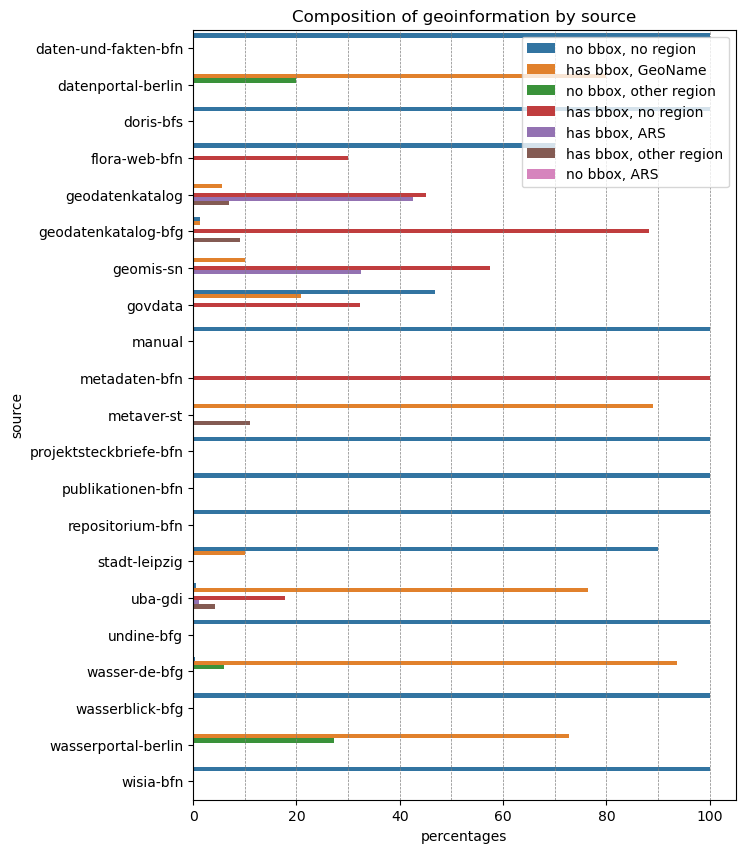

In [20]:
plt.figure(figsize=(7, 10))
barplot = sns.barplot(
    data=counts_merge,
    x="percentages",
    y="source",
    hue="geo_category",
    errorbar=None,
)

if barplot.legend_:
    barplot.legend_.remove()

handles, labels = barplot.get_legend_handles_labels()
barplot.legend(
    handles=handles,
    title_fontsize="13",
    loc="upper right",
)

# add vertical lines for every x-tick
for x in range(0, 101, 10):
    plt.axvline(x, color="gray", linestyle="--", linewidth=0.5)

plt.title("Composition of geoinformation by source")
plt.show()